# TP2 Mean Shift

Read, understand, and complete and run the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). 

Return your work by e-mail using a single file (ipynb or zip) with the format 'introvis18_tp2_yourname.ipynb'


## 0. Imports

In [3]:
import numpy as np 
# this is the key library for manipulating arrays. Use the online ressources! http://www.numpy.org/

import matplotlib.pyplot as plt 
# used to read images, display and plot http://matplotlib.org/api/pyplot_api.html . 
#You can also check this simple intro to using ipython notebook with images https://matplotlib.org/users/image_tutorial.html

#%matplotlib inline 
# to display directly in the notebook

import scipy.ndimage as ndimage
# one of several python libraries for image procession

plt.rcParams['image.cmap'] = 'gray' 
# by default, the grayscale images are displayed with the jet colormap: use grayscale instead

from skimage.color import rgb2luv,luv2rgb
# for colorspace conversions

import random as rd

from drawnow import drawnow

## 1. Mean shift

In this section, we will implement Mean Shift and test is on simple synthetic data (i.e. points you will sample from a probability distribution with known density - see below).

1: Generate a random vector of 100 2D points 'data1' with 50 points sampled from a Gaussian distribution of variance 1 centered in (0,0) and 50 points sampled from a Gaussian distribution of variance 1 centered in (2,1). Plot your points using the 'plt.scatter' function. This 'data' vector will be the synthetic data you will try to cluster, and for which the algorithm should manage to separate the point coming from each of the two Gaussians. Repeat to create a vector 'data2' with the center of the second Gaussian in (3,3). Which will be the easiest data vector to cluster? Test both in the following experiments.

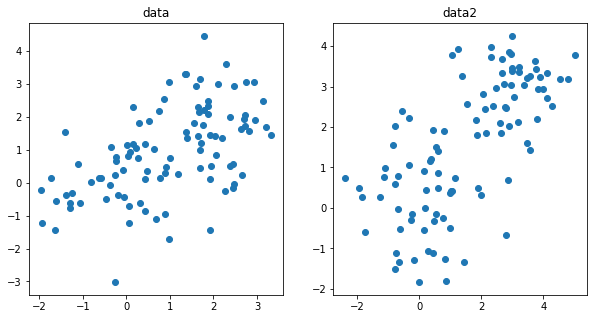

In [4]:
def compute_vector(mean1, var1, mean2, var2, nb_points):
    
    N = nb_points//2
    
    data1 = np.random.multivariate_normal(2*[mean1], np.diag(2*[var1]), N)
    data2 = np.random.multivariate_normal(2*[mean2], np.diag(2*[var2]), N)
    
    return np.concatenate((data1, data2))


data = compute_vector(0, 1, 2, 1, 100)
data2 = compute_vector(0, 1, 3, 1, 100) # plus facile à clusteriser car les 2 nuages de points sont plus espacés

fig = plt.figure(figsize = (10,5))
    
ax = fig.add_subplot(1, 2, 1)
ax.set_title("data")
ax.scatter(*data.T)
    
ax = fig.add_subplot(1, 2, 2)
ax.set_title("data2")
ax.scatter(*data2.T)

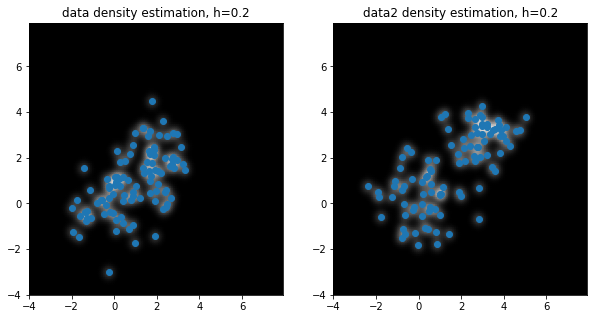

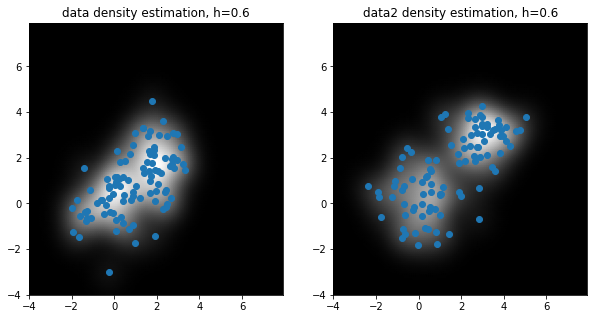

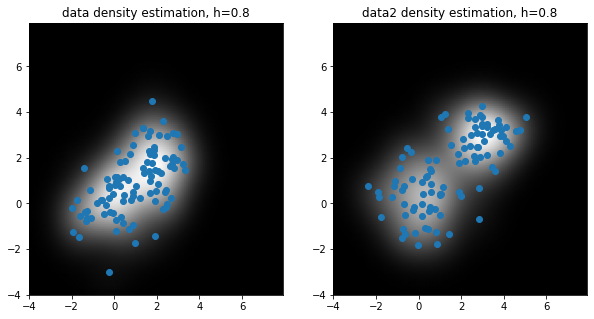

In [5]:
def k_n(r):
    return np.exp(-0.5*r)

def k_e(r):
    return max(0, 1-r)

def norm2(x):
    return np.sum(x**2)

def kernel_density_estimator(x, y, data, h, k=k_n):
    n = len(data)
    sum = 0
    for i in range(n):
        sum += k( ((x-data[i][0])**2 + (y-data[i][1])**2)/(h**2) )
    return sum/(len(data) * h)

x = np.arange(-4,8,0.1)    
X,Y = np.meshgrid(x,x)

Test = [0.2, 0.6, 0.8]
for t in Test:
    
    fig = plt.figure(figsize = (10,5))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("data density estimation, h="+str(t))
    ax.pcolormesh(X, Y, kernel_density_estimator(X,Y, data, t, k_n), shading="gouraud")
    ax.scatter(*data.T)

    
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title("data2 density estimation, h="+str(t))
    ax.pcolormesh(X, Y, kernel_density_estimator(X,Y, data2, t), shading="gouraud")
    ax.scatter(*data2.T)

plt.show()


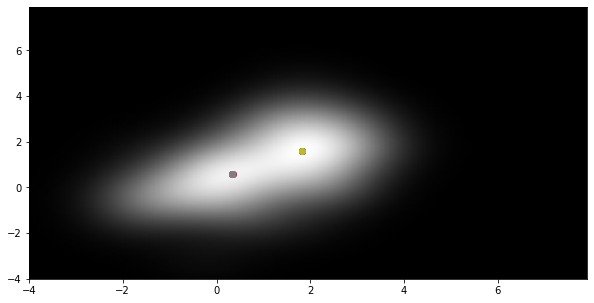

In [25]:
def k_pn(r):
    return -0.5*k_n(r)

def k_pe(r):
    return -1 if r<0 else 0


def m(elem, data, h, dist=norm2, kernel=k_pn):
    n = len(data)
    sum1 = 0
    sum2 = 0
    for i in range(n):
        ker = -kernel( dist((elem-data[i])/h) )
        sum1 += data[i]* ker
        sum2 += ker
        
    return sum1/(sum2 + 1e-16)


def mean_shift_algo(elem, data, h, eps =0.000001, kernel=k_pn, dist=norm2 ):
    
    elem2 = m(elem, data, h, dist, kernel)
    while dist(elem2-elem) > eps:
        elem = elem2
        elem2 = m(elem, data, h, dist, kernel)
        
    return elem2



H = 0.8

x = np.arange(-4,8,0.1)    
X,Y = np.meshgrid(x,x)
plt.figure(figsize=(10,5))
plt.pcolormesh(X, Y, kernel_density_estimator(X, Y, data, H ), shading="gouraud")

for i in range(99):
    converge = mean_shift_algo(data2[i], data, H, kernel=k_pn)
    plt.scatter(*converge)

plt.show()

## 2. Segmentation

1: Download [this small image](http://imagine.enpc.fr/~aubrym/lectures/introvis17/legumes_small.jpg), load it and convert it to the Lab colorspace. Why is it necessary to change colorspace? What are the range of the colorvalues in Lab? 

In [232]:
def Ksr(x, hs, hr, k=k_n):
    

def Img_to_data(Img):
    Out = []
    for i in range(Img.shape[0]):
        for j in range(Img.shape[1]):
            Out.append([i,j,*Img[i][j]])
    return np.array(Out)


def ms_filtering(Img, hs, hr):
    data = Img_to_data(Img)
    z = np.zeros(data.shape)
    for i in range(len(data)):
        y_i  = mean_shift_algo(elem, data, h)
        while

name='legumes_small.jpg'

I = plt.imread(name)
Img_to_data(I)

array([[list([0, 0]), array([225, 223, 226], dtype=uint8)],
       [list([0, 1]), array([225, 223, 226], dtype=uint8)],
       [list([0, 2]), array([225, 223, 226], dtype=uint8)],
       ...,
       [list([61, 47]), array([242, 241, 246], dtype=uint8)],
       [list([61, 48]), array([242, 241, 246], dtype=uint8)],
       [list([61, 49]), array([242, 241, 246], dtype=uint8)]],
      dtype=object)

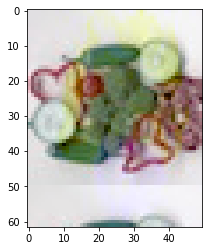

In [208]:
for i in range(I.shape[0]):
    print('step: '+str(i+1)+'/'+str(I.shape[0])+'\r', sep=' ', end='', flush=True)
    for j in range(I.shape[1]):
        I_luv[i][j] = [*I_list[i+I.shape[1]*j], I_luv[i][j][2]]

        
plt.imshow(luv2rgb(I_luv))

2: In Mean Shift segmentation, all pixels in the image will be treated as data points including both their color and position in the image. Convert the (N,M,3) image into an (NM,5) array incuding color and position information for each point. What would be a meaningful value for sigma?

Tip: use the np.meshgrid function

3: Use the MS function from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated to each mode by the color of the mode.